<a href="https://colab.research.google.com/github/brianbaert/MscThesis/blob/main/MscThesis_Playground.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Packages

In [ ]:
!python --version

Python 3.10.12


In [ ]:
#!pip install gwosc
#!pip install gwpy
!pip install avalanche_lib[all]
!pip show avalanche-lib

In [ ]:
import numpy as np
import os
import pandas as pd
import torch
import torchvision
import torchvision.transforms as transforms
import torch
import torch.nn as nn
#import gwosc
#import gwpy
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torchvision.datasets import DatasetFolder, ImageFolder
from tqdm import tqdm
from sklearn import model_selection
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
#from gwpy.segments import Segment
#from gwpy.spectrogram import Spectrogram
#from gwpy.timeseries import TimeSeries

import my_utils

#def checkpoint(model, filename):
#    torch.save(model.state_dict(), filename)

#def resume(model, filename):
#    model.load_state_dict(torch.load(filename))

# Preliminaries and visualization

In [ ]:
dir = '/content/drive/MyDrive/MscThesis'

In [ ]:
df_data_o3a = pd.read_csv(dir + '/data_o3a_high_confidence.csv')

In [ ]:
df_data_o3a.head()

,Unnamed: 0,GPStime,peakFreq,snr,amplitude,centralFreq,duration,bandwidth,chisq,chisqDof,confidence,id,ifo,label,imgUrl,Q-value
0,0,1.239157e+09,62.976,19989.938,2.580000e-19,3983.241,13.524,7934.48291,0.0,0.0,1.0,R7q36rPK5J,V1,Extremely_Loud,https://ldas-jobs.ligo.caltech.edu/~gravityspy...,11.314
1,1,1.252630e+09,30.734,14050.200,1.730000e-19,3980.241,8.250,7940.48291,0.0,0.0,1.0,xg6I5indL7,L1,Extremely_Loud,https://ldas-jobs.ligo-la.caltech.edu/~gravity...,11.314
2,2,1.242889e+09,39.789,12802.310,1.020000e-19,3980.241,10.669,7940.48291,0.0,0.0,1.0,puprGzhePt,L1,Extremely_Loud,https://ldas-jobs.ligo-la.caltech.edu/~gravity...,11.314
3,3,1.243172e+09,39.789,12470.565,1.030000e-19,3980.241,7.875,7940.48291,0.0,0.0,1.0,wVuUvshkGV,L1,Extremely_Loud,https://ldas-jobs.ligo-la.caltech.edu/~gravity...,11.314
4,4,1.248612e+09,30.734,11933.828,2.330000e-19,3980.241,13.000,7940.48291,0.0,0.0,1.0,RcVMzIZSn3,H1,Extremely_Loud,https://ldas-jobs.ligo-wa.caltech.edu/~gravity...,11.314


In [ ]:
df_data_o3a.columns

Index(['Unnamed: 0', 'GPStime', 'peakFreq', 'snr', 'amplitude', 'centralFreq',
       'duration', 'bandwidth', 'chisq', 'chisqDof', 'confidence', 'id', 'ifo',
       'label', 'imgUrl', 'Q-value'],
      dtype='object')

In [ ]:
glitch_labels = df_data_o3a.label.unique()
glitch_labels

array(['Extremely_Loud', 'Scattered_Light', 'Scratchy',
       'Power_Line', 'Koi_Fish', 'Whistle',
       'Low_Frequency_Burst', 'Tomte', 'Repeating_Blips',
       'Fast_Scattering', 'Blip', 'Blip_Low_Frequency',
       'Violin_Mode', 'Helix', 'None_of_the_Above',
       'Low_Frequency_Lines', 'Wandering_Line', 'No_Glitch',
       'Air_Compressor', 'Chirp', 'Light_Modulation',
       'Paired_Doves', '1400Ripples', '1080Lines'], dtype=object)

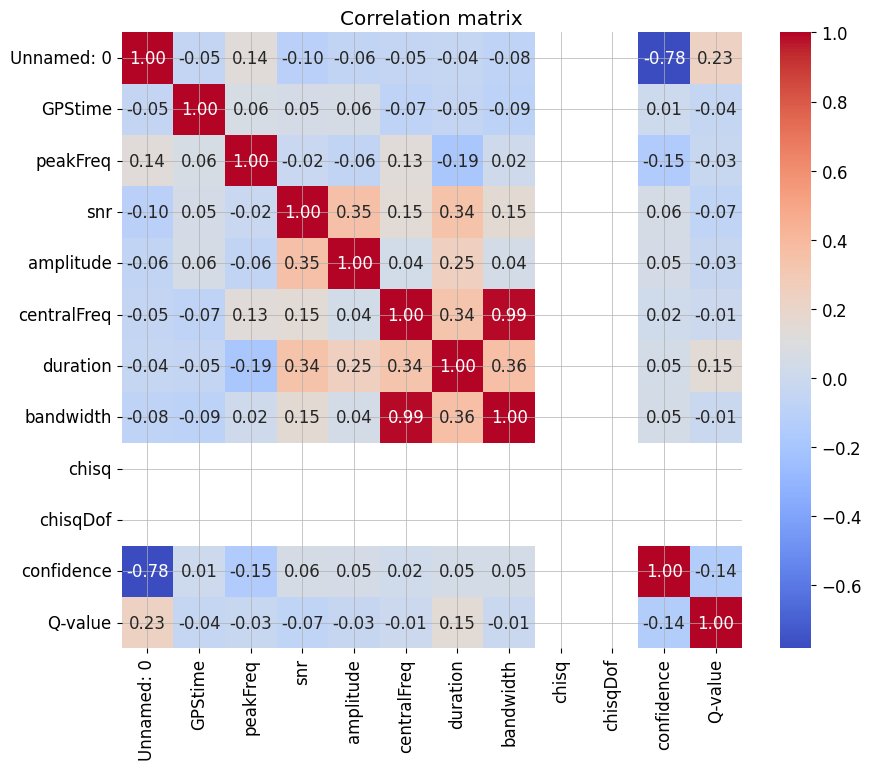

In [ ]:
#correlation matrix
corr_matrix = df_data_o3a.select_dtypes(include=np.number).corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Correlation matrix")
plt.show()

In [ ]:
from gwpy.table import GravitySpyTable
zenodo_address = "https://zenodo.org/record/5649212/files/"
L1_O3a = GravitySpyTable.read(zenodo_address + 'L1_O3a.csv')
df_L1_O3a = L1_O3a.to_pandas()
df_L1_O3a.head()

,event_time,ifo,peak_time,peak_time_ns,start_time,start_time_ns,duration,peak_frequency,central_freq,bandwidth,...,Tomte,Violin_Mode,Wandering_Line,Whistle,ml_label,ml_confidence,url1,url2,url3,url4
0,1.253102e+09,L1,1253102470,687500000,1253102469,250000000,3.00000,19.519409,3981.425049,7938.115723,...,0.000012,0.000018,0.000005,0.001016,Scattered_Light,0.514198,https://panoptes-uploads.zooniverse.org/produc...,https://panoptes-uploads.zooniverse.org/produc...,https://panoptes-uploads.zooniverse.org/produc...,https://panoptes-uploads.zooniverse.org/produc...
1,1.253094e+09,L1,1253093509,929687023,1253093509,812500000,0.18750,27.308241,31.582130,25.333481,...,0.004336,0.001223,0.000011,0.000707,Fast_Scattering,0.710608,https://panoptes-uploads.zooniverse.org/produc...,https://panoptes-uploads.zooniverse.org/produc...,https://panoptes-uploads.zooniverse.org/produc...,https://panoptes-uploads.zooniverse.org/produc...
2,1.253100e+09,L1,1253100460,937500000,1253100459,216797113,7.28320,23.330521,3879.200928,7737.094238,...,0.000008,0.000053,0.000017,0.002770,Scattered_Light,0.966866,https://panoptes-uploads.zooniverse.org/produc...,https://panoptes-uploads.zooniverse.org/produc...,https://panoptes-uploads.zooniverse.org/produc...,https://panoptes-uploads.zooniverse.org/produc...
3,1.253095e+09,L1,1253095251,347656011,1253095251,0,0.50000,39.789299,53.285130,60.826618,...,0.316067,0.064872,0.000545,0.003618,Tomte,0.995652,https://panoptes-uploads.zooniverse.org/produc...,https://panoptes-uploads.zooniverse.org/produc...,https://panoptes-uploads.zooniverse.org/produc...,https://panoptes-uploads.zooniverse.org/produc...
4,1.253068e+09,L1,1253068267,767638921,1253068267,761718034,0.00977,1822.457886,2085.644043,2028.357178,...,0.000007,0.007593,0.000018,0.035755,No_Glitch,0.567025,https://panoptes-uploads.zooniverse.org/produc...,https://panoptes-uploads.zooniverse.org/produc...,https://panoptes-uploads.zooniverse.org/produc...,https://panoptes-uploads.zooniverse.org/produc...


In [ ]:
L1_O3a[(L1_O3a["ml_label"] == "Blip") & (L1_O3a["ml_confidence"] > 0.9)]
L1_O3a[0:4].download(nproc=1)

['download/L1_kowIJ4aqgf_spectrogram_0.5.png',
 'download/L1_kowIJ4aqgf_spectrogram_1.0.png',
 'download/L1_kowIJ4aqgf_spectrogram_2.0.png',
 'download/L1_kowIJ4aqgf_spectrogram_4.0.png',
 'download/L1_kpnnKtzbiA_spectrogram_0.5.png',
 'download/L1_kpnnKtzbiA_spectrogram_1.0.png',
 'download/L1_kpnnKtzbiA_spectrogram_2.0.png',
 'download/L1_kpnnKtzbiA_spectrogram_4.0.png',
 'download/L1_lE75WVo0mb_spectrogram_0.5.png',
 'download/L1_lE75WVo0mb_spectrogram_1.0.png',
 'download/L1_lE75WVo0mb_spectrogram_2.0.png',
 'download/L1_lE75WVo0mb_spectrogram_4.0.png',
 'download/L1_lRvxjOas61_spectrogram_0.5.png',
 'download/L1_lRvxjOas61_spectrogram_1.0.png',
 'download/L1_lRvxjOas61_spectrogram_2.0.png',
 'download/L1_lRvxjOas61_spectrogram_4.0.png']

In [ ]:
def glitch_time(run='O3a',ifo='L1', n=1):

  ifo_run = ifo + '_' + run + '.csv'
  filename = zenodo_address+ ifo_run

  df = pd.read_csv(filename)
  gpstimes = df['event_time'].sample(n).tolist()

  return gpstimes

In [ ]:
def make_scan(event_time, ifo):
    try:
        print("Getting the Timeseries data")
        data = TimeSeries.fetch_open_data(ifo, event_time - 10, event_time + 10)
        print("Obtaining the Q transform")
        q_data = data.q_transform(outseg=Segment(event_time - 1, event_time + 1))
    except ValueError:
        q_data = None
        print('Data surrounding this time is not available. Please try another gpstime.')

    if q_data is not None:
        print("Plotting the Q transform")
        plot = q_data.plot(figsize=[8,4])
        ax = plot.gca()
        ax.set_xscale('seconds')
        ax.set_yscale('log')
        ax.set_ylim(20,500)
        ax.set_ylabel('Frequency [Hz]')
        ax.grid(True, axis='y', which='both')
        ax.colorbar(cmap='viridis', label='Normalized Energy')
        plot.show()
    else:
        pass


In [ ]:
glitch_times = glitch_time(run='O3a', ifo='L1', n=3)

Getting the Timeseries data
Obtaining the Q transform
Plotting the Q transform


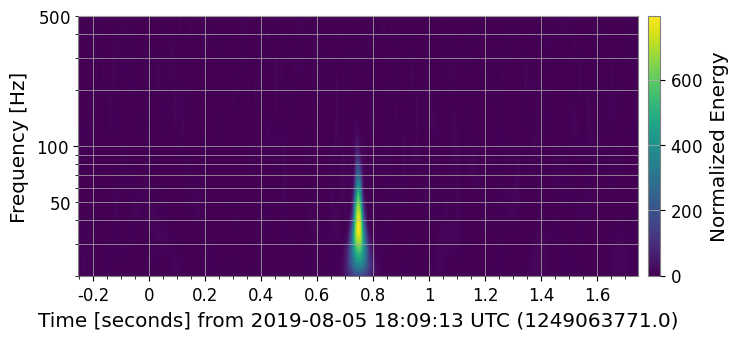

In [ ]:
make_scan(glitch_times[0], 'L1')

/usr/local/lib/python3.10/dist-packages/avalanche/training/templates/base.py:468: PositionalArgumentsDeprecatedWarning: Avalanche is transitioning to strategy constructors that accept named (keyword) arguments only. This is done to ensure that there is no confusion regarding the meaning of each argument (strategies can have many arguments). Your are passing 3 positional arguments to the Naive.__init__ method. Consider passing them as names arguments. The ability to pass positional arguments will be removed in the future.
  warnings.warn(error_str, category=PositionalArgumentsDeprecatedWarning)


# DL Baseline

In [ ]:
from torch.utils.tensorboard import SummaryWriter

train_dir = '/content/drive/MyDrive/MscThesis/GravitySpy/train/train'
val_dir = '/content/drive/MyDrive/MscThesis/GravitySpy/validation/validation'
test_dir = '/content/drive/MyDrive/MscThesis/GravitySpy/test/test'
#metadata_o3b = '/content/drive/MyDrive/MscThesis/data_o3b_high_confidence.csv'
#metadata_o3a = '/content/drive/MyDrive/MscThesis/data_o3a_high_confidence.csv'
#metadata_o1L1 = '/content/drive/MyDrive/MscThesis/GravitySpy/L1_O1.csv'
#metadata_o2L1 = '/content/drive/MyDrive/MscThesis/GravitySpy/L1_O2.csv'
IMG_SIZE = (224,224)

In [ ]:
meta_o3a_df = pd.read_csv(metadata_o3a)
meta_o3b_df = pd.read_csv(metadata_o3b)
meta_o1_df = pd.read_csv(metadata_o1L1)
meta_o2_df = pd.read_csv(metadata_o2L1)

In [ ]:
meta_train_v1 = pd.read_csv('/content/drive/MyDrive/MscThesis/GravitySpy/trainingset_v1d1_metadata.csv')
print(meta_train_v1[meta_train_v1['sample_type']=='train']['label'].value_counts())
classes = meta_train_v1['label'].unique()
classes

Blip                   1274
Koi_Fish                498
Low_Frequency_Burst     437
Light_Modulation        361
Extremely_Loud          316
Low_Frequency_Lines     315
Power_Line              314
Scattered_Light         308
Violin_Mode             284
Scratchy                237
1080Lines               229
Whistle                 208
Helix                   195
Repeating_Blips         185
No_Glitch               107
Tomte                    73
1400Ripples              59
None_of_the_Above        57
Air_Compressor           41
Chirp                    41
Wandering_Line           29
Paired_Doves             19
Name: label, dtype: int64


array(['Whistle', '1080Lines', 'Blip', 'Violin_Mode', 'Scattered_Light',
       'Power_Line', 'Light_Modulation', 'Koi_Fish', 'None_of_the_Above',
       'Scratchy', 'Tomte', 'Chirp', 'Wandering_Line', 'Extremely_Loud',
       'Repeating_Blips', 'No_Glitch', 'Low_Frequency_Lines',
       'Paired_Doves', 'Low_Frequency_Burst', 'Helix', 'Air_Compressor',
       '1400Ripples'], dtype=object)

In [ ]:
train_classes = [d for d in next(os.walk(train_dir))[1] if os.path.isdir(os.path.join(train_dir, d))]
train_classes = train_classes.sort()
train_class_to_indx = {c: i for i, c in enumerate(classes)}
test_classes = classes = [d for d in next(os.walk(test_dir))[1] if os.path.isdir(os.path.join(test_dir, d))]
test_classes = test_classes.sort()
test_class_to_indx = {c: i for i, c in enumerate(classes)}
val_classes = classes = [d for d in next(os.walk(val_dir))[1] if os.path.isdir(os.path.join(val_dir, d))]
val_classes = val_classes.sort()
val_class_to_indx = {c: i for i, c in enumerate(classes)}

In [ ]:
train_classes = [d for d in next(os.walk(train_dir))[1] if os.path.isdir(os.path.join(train_dir, d))]
classes = train_classes
class_to_indx = {c: i for i, c in enumerate(classes)}

In [ ]:
import os
from PIL import Image
from collections import Counter

class GravitySpy_1_0_dataset(ImageFolder):
  def __init__(self, root, cls, transform=None):
    self.data_dir = root
    #self.classes = [d for d in next(os.walk(root))[1] if os.path.isdir(os.path.join(root, d))]
    self.classes = cls
    self.class_to_indx = {c: i for i, c in enumerate(self.classes)}
    self.image_paths=[]
    self.labels=[]
    #self.targets = []
    for class_name in self.classes:
      class_path = os.path.join(root, class_name)
      for filename in os.listdir(class_path):
        if filename.endswith("1.0.png"):
          self.image_paths.append(os.path.join(class_path, filename))
          self.labels.append(self.class_to_indx[class_name])
          #self.targets.append(self.class_to_indx[class_name])
    self.transform = transform

  def __len__(self):
    return len(self.image_paths)

  def __getitem__(self, idx):
    image_path = self.image_paths[idx]
    image = Image.open(image_path)
    image = image.convert('RGB')
    label = self.labels[idx]
    #target = self.targets[idx]

    if self.transform:
      image = self.transform(image)

    #return image, label
    return image, label

  def count_class_instances(self):
    label_counts = Counter(self.labels)
    #target_counts = Counter(self.targets)
    return label_counts
    #return target_counts

class GravitySpy_0_5_dataset(ImageFolder):
  def __init__(self, root, cls, transform=None):
    self.data_dir = root
    #self.classes = [d for d in next(os.walk(root))[1] if os.path.isdir(os.path.join(root, d))]
    self.classes = cls
    self.class_to_indx = {c: i for i, c in enumerate(self.classes)}
    self.image_paths=[]
    self.labels=[]
    for class_name in self.classes:
      class_path = os.path.join(root, class_name)
      for filename in os.listdir(class_path):
        if filename.endswith("0.5.png"):
          self.image_paths.append(os.path.join(class_path, filename))
          self.labels.append(self.class_to_indx[class_name])
    self.transform = transform

  def __len__(self):
    return len(self.image_paths)

  def __getitem__(self, idx):
    image_path = self.image_paths[idx]
    image = Image.open(image_path)
    image = image.convert('RGB')
    label = self.labels[idx]

    if self.transform:
      image = self.transform(image)

    return image, label

  def count_class_instances(self):
    label_counts = Counter(self.labels)
    return label_counts

In [ ]:
transform = transforms.Compose([
     transforms.Resize((140,170)),
     transforms.Grayscale(num_output_channels=1),
     transforms.ToTensor(),
     transforms.Normalize((0.5),(0.5))
     #transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

transformAV = transforms.Compose([
     transforms.Resize((32,32)),
     transforms.ToTensor(),
     transforms.Normalize((0.5),(0.5))
     #transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

In [ ]:
train_set = GravitySpy_1_0_dataset(root=train_dir, cls=classes, transform=transform)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=32, shuffle=True)

val_set = GravitySpy_1_0_dataset(root=val_dir, cls=classes, transform=transform)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=16, shuffle=True)

test_set = GravitySpy_1_0_dataset(root=test_dir, cls=classes, transform=transform)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=1, shuffle=True)

In [ ]:
train_set = GravitySpy_0_5_dataset(root=train_dir, cls=classes, transform=transform)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=32, shuffle=True)

val_set = GravitySpy_0_5_dataset(root=val_dir, cls=classes, transform=transform)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=16, shuffle=True)

test_set = GravitySpy_0_5_dataset(root=test_dir, cls=classes, transform=transform)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=1, shuffle=True)

In [ ]:
print("The training loader contains {} instances, the val loader contains {} instances and the test loader contains {} instances".format(len(train_loader), len(val_loader), len(test_loader)))

The training loader contains 175 instances, the val loader contains 75 instances and the test loader contains 1180 instances


In [ ]:
class_counts = train_set.count_class_instances()
class_weights = []
for class_name, count in class_counts.items():
  print(f"{class_name}: {count} instances")
  class_weights.append(1.0/(count/len(train_set)))
  #class_weights.append(count/len(train_set))

0: 73 instances
1: 314 instances
2: 308 instances
3: 29 instances
4: 208 instances
5: 185 instances
6: 237 instances
7: 284 instances
8: 361 instances
9: 41 instances
10: 437 instances
11: 19 instances
12: 195 instances
13: 316 instances
14: 315 instances
15: 498 instances
16: 107 instances
17: 57 instances
18: 41 instances
19: 59 instances
20: 229 instances
21: 1274 instances


In [ ]:
#classes = test_set.classes.sort()
print(class_weights)

[76.53424657534246, 17.792993630573246, 18.13961038961039, 192.6551724137931, 26.860576923076923, 30.2, 23.57383966244726, 19.672535211267604, 15.476454293628809, 136.26829268292684, 12.784897025171624, 294.0526315789474, 28.651282051282053, 17.680379746835442, 17.736507936507937, 11.218875502008032, 52.21495327102804, 98.01754385964912, 136.26829268292684, 94.6949152542373, 24.397379912663755, 4.385400313971743]


**Single view model (Bahaadini)**

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SingleViewModel(nn.Module):
    def __init__(self):
        super(SingleViewModel, self).__init__()

        # First Convolutional Layer with Regularization
        self.conv1 = nn.Conv2d(3, 32, kernel_size=5, stride=1, padding=2)
        self.batch_norm1 = nn.BatchNorm2d(32)

        # Second Convolutional Layer with Regularization
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2)
        self.batch_norm2 = nn.BatchNorm2d(64)

        # Fully Connected Layer
        self.fc1 = nn.Linear(64*35*42, 256)

        # Output Layer
        self.fc2 = nn.Linear(256, 22)

    def forward(self, x):
        # Applying first conv layer followed by maxpool and dropout
        x = F.relu(self.batch_norm1(self.conv1(x)))
        x = F.max_pool2d(x, kernel_size=2, stride=2)
        x = F.dropout(x, p=0.5)

        # Applying second conv layer followed by maxpool and dropout
        x = F.relu(self.batch_norm2(self.conv2(x)))
        x = F.max_pool2d(x, kernel_size=2, stride=2)
        x = F.dropout(x, p=0.5)

        # Flattening the tensor output before feeding it to fully connected layers
        x = x.view(-1, self.num_flat_features(x))

        # Applying fully connected layer followed by dropout
        x = F.relu(self.fc1(x))
        x = F.dropout(x, p=0.05)

        # Output layer with softmax activation function
        out = self.fc2(x)
        return out

    def num_flat_features(self, x):
        size = x.size()[1:]  # All dimensions except batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

# Creating an object of the defined model class and printing it to see the architecture
net = SingleViewModel()
print(net)


SingleViewModel(
  (conv1): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (batch_norm1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (batch_norm2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=94080, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=22, bias=True)
)


**Resnet18 Learning architecture**

In [ ]:
import torch
from torchvision import models

class GrayscaleNet(nn.Module):
    def __init__(self):
        super(GrayscaleNet, self).__init__()
        self.resnet = models.resnet18(pretrained=True)
        self.resnet.conv1 = torch.nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        for param in self.resnet.parameters():
          param.requires_grad = True  #Unfreeze all parameters
        num_features_in = self.resnet.fc.in_features
        self.resnet.fc = nn.Linear(num_features_in, 22)

    def forward(self, x):
        x = self.resnet(x)
        return x

net = GrayscaleNet()
print(net)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 124MB/s]


GrayscaleNet(
  (resnet): ResNet(
    (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

In [ ]:
from torch import nn
from torchvision import models
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.resnet = models.resnet18(pretrained=True)
        for param in self.resnet.parameters():
          param.requires_grad = True  #Unfreeze all parameters
        num_features_in = self.resnet.fc.in_features
        self.resnet.fc = nn.Linear(num_features_in, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 22) # 22 classes in GravitySpy dataset
        self.dropout = nn.Dropout(p=0.3)
        self.bn = nn.BatchNorm1d(120)

    def forward(self, x):
        x = self.resnet(x)
        x = self.bn(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

net = Net()
print(net)


In [ ]:
def calculate_accuracy(outputs, labels):
  _, predicted = torch.max(outputs.data, 1)  # Get the index of the maximum value
  correct = (predicted == labels).sum().float()
  accuracy = correct / len(labels)
  return accuracy

In [ ]:
import torch.optim as optim
import torch.nn.functional as F
import time
from datetime import datetime

epoch_test_loss = 0
epoch_test_acc = 0
epoch_test_correct = 0
epoch_test_total = 0

best_vloss = 1_000_000.

avg_loss = 0
last_loss = 0

timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')

writer = SummaryWriter('runs/glitch_baseline_0_5_{}'.format(timestamp))

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss(weight=torch.tensor(class_weights, dtype=torch.float32), label_smoothing=0.2)
optimizer = optim.Adam(net.parameters(), lr=0.001, weight_decay=1e-3) #LR from the study of Tiago Fernandes

# Number of epochs to train for
num_epochs = 10
epoch_number = 0

start = time.time()
for epoch in range(num_epochs):  # loop over the dataset multiple times
  total_correct = 0
  total_samples = 0
  print('EPOCH {}:'.format(epoch_number + 1))
  running_loss = 0.0
  net.train(True)

  ## TRAINING ONE EPOCH
  for i, data in enumerate(train_loader):
    # get the inputs; data is a list of [inputs, labels]
    inputs, labels = data
    # zero the parameter gradients
    optimizer.zero_grad()

    # forward + backward + optimize
    outputs = net(inputs)
    _, predicted = torch.max(outputs, 1)

    # compute loss and gradient
    loss = criterion(outputs, labels)

    #add part of regularization
    l2_reg = torch.tensor(0.0)
    for param in net.parameters():
      if param.requires_grad: #exclude frozen layers
        l2_reg += torch.norm(param, p=2)
    loss += 1e-5 * l2_reg
    #end part of regularization
    loss.backward()

    # adjust learning weights
    optimizer.step()

    # print statistics
    running_loss += loss.item()
    total_correct += (predicted == labels).sum().item()
    total_samples += labels.size(0)

    if i % 10 == 9:
      last_loss = running_loss / 10
      print('  batch {} loss: {}, acc: {}'.format(i+1, last_loss, 100*total_correct/total_samples))
      tb_x = epoch * len(train_loader) + i + 1
      running_loss=0.
    avg_loss = last_loss

  running_vloss = 0.0
  net.eval()

  # disable gradient computation for validation
  with torch.no_grad():
    for i, vdata in enumerate(val_loader):
      vinputs, vlabels = vdata
      voutputs = net(vinputs)
      vloss = criterion(voutputs, vlabels)
      running_vloss += vloss
  avg_vloss = running_vloss / (i+1)
  print('LOSS train{} valid {} after {} seconds'.format(avg_loss, avg_vloss, time.time()-start))

  writer.add_scalars('Training vs. Validation Loss', { 'Training': avg_loss, ' Validation' : avg_vloss}, epoch_number + 1)
  writer.flush()

  if avg_vloss < best_vloss:
    best_vloss = avg_vloss
    model_path = 'model_{}_{}'.format(timestamp, epoch_number)
    torch.save(net.state_dict(), model_path)
  checkpoint(net, f"epoch-{epoch}.pth")
  epoch_number += 1

end = time.time()
print('Training finished after ', end-start, ' seconds')

EPOCH 1:
  batch 10 loss: 3.653530144691467, acc: 21.5625
  batch 20 loss: 3.608169198036194, acc: 35.78125
  batch 30 loss: 3.3392590045928956, acc: 41.979166666666664
  batch 40 loss: 3.3119160890579225, acc: 42.734375
  batch 50 loss: 3.080129384994507, acc: 47.125
  batch 60 loss: 2.8833752155303953, acc: 47.8125
  batch 70 loss: 3.1119271755218505, acc: 51.294642857142854
  batch 80 loss: 2.8243507862091066, acc: 52.4609375
  batch 90 loss: 2.9284590244293214, acc: 55.24305555555556
  batch 100 loss: 2.8237807512283326, acc: 57.03125
  batch 110 loss: 2.8304229617118835, acc: 57.86931818181818
  batch 120 loss: 2.8473780512809754, acc: 58.880208333333336
  batch 130 loss: 2.8590214252471924, acc: 59.47115384615385
  batch 140 loss: 2.6812629222869875, acc: 60.75892857142857
  batch 150 loss: 2.8183379054069517, acc: 61.020833333333336
  batch 160 loss: 2.787886881828308, acc: 62.05078125
  batch 170 loss: 2.5281642079353333, acc: 62.70220588235294
LOSS train2.5281642079353333 vali

In [ ]:
#save model
torch.save(net.state_dict(), '/content/drive/MyDrive/MscThesis/thesis_baseline_finetune_0_5.pth')
print("Saved Pytorch Model state to thesis_baseline.pth")

Saved Pytorch Model state to thesis_baseline.pth


In [ ]:
net.eval()
temp = 0
for i, sample in test_loader:
  if temp!=10:
    x = i
    y = sample[0]
    with torch.no_grad():
      pred = net(x)
      predicted, actual = classes[pred[0].argmax(0)], classes[y]
      print(f'Predicted: "{predicted}", Actual: "{actual}"')
    temp+=1
  else:
    break

Predicted: "Tomte", Actual: "Blip"
Predicted: "Paired_Doves", Actual: "Wandering_Line"
Predicted: "Light_Modulation", Actual: "Light_Modulation"
Predicted: "Tomte", Actual: "Blip"
Predicted: "Low_Frequency_Lines", Actual: "Low_Frequency_Lines"
Predicted: "Blip", Actual: "Blip"
Predicted: "Tomte", Actual: "Blip"
Predicted: "Tomte", Actual: "Blip"
Predicted: "Tomte", Actual: "Blip"
Predicted: "Low_Frequency_Burst", Actual: "Low_Frequency_Burst"


In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix
import torch

def get_predictions(model, dataloader):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in dataloader:

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    return all_preds, all_labels

#y_pred_list, y_true_list = get_predictions(net, test_loader)



In [ ]:
# Generate confusion matrix
from sklearn.metrics import f1_score
cm = confusion_matrix(y_true_list, y_pred_list)
f1 = f1_score(y_true_list, y_pred_list, average=None)

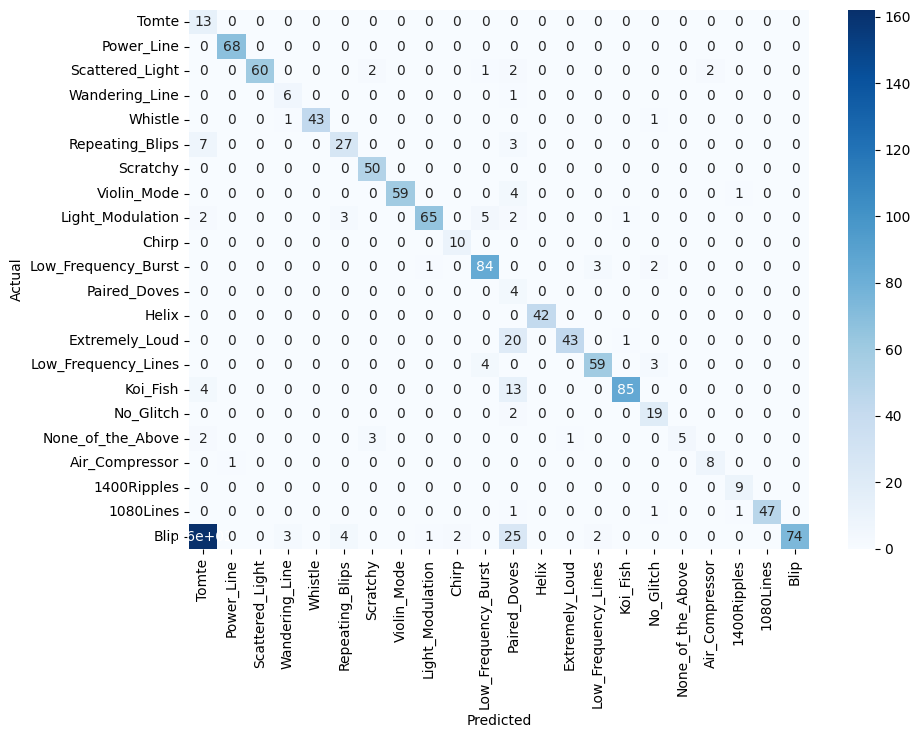

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,7))

# Use seaborn heatmap for visualization
sns.heatmap(cm, annot=True, cmap='Blues', xticklabels=classes, yticklabels=classes)

plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.show()


In [ ]:
print(f"F1 Score for each class: {f1}")
print(f"The average F1 score is: {f1_score(y_true_list, y_pred_list, average='weighted')}")

F1 Score for each class: [0.12807882 0.99270073 0.94488189 0.70588235 0.97727273 0.76056338
 0.95238095 0.95934959 0.89655172 0.90909091 0.91304348 0.09876543
 1.         0.7962963  0.90769231 0.8994709  0.80851064 0.625
 0.84210526 0.9        0.96907216 0.42651297]
The average F1 score is: 0.7874444080330263


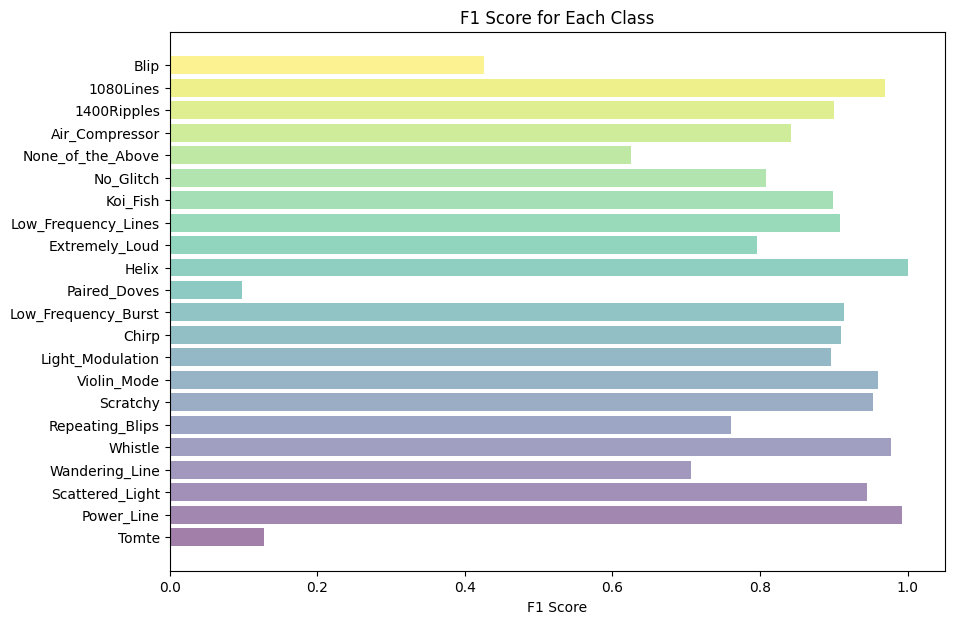

In [ ]:
# Create a horizontal bar plot for F1 scores with different colors
plt.figure(figsize=(10,7))
colors = plt.cm.viridis(np.linspace(0, 1, len(classes)))
plt.barh(np.arange(len(classes)), f1, color=colors, align='center', alpha=0.5)
plt.yticks(np.arange(len(classes)), classes)
plt.xlabel('F1 Score')
plt.title('F1 Score for Each Class')

plt.show()

#Avalanche experiment

In [ ]:
from avalanche.models import SlimResNet18
from avalanche.training import Naive, LwF
from avalanche.logging import InteractiveLogger, TextLogger
from avalanche.training.plugins import EvaluationPlugin
from avalanche.evaluation.metrics import forgetting_metrics, accuracy_metrics,loss_metrics, \
timing_metrics, cpu_usage_metrics, StreamConfusionMatrix,disk_usage_metrics, gpu_usage_metrics, \
confusion_matrix_metrics
from torch.optim import SGD, Adam
from torch.nn import CrossEntropyLoss
from avalanche.benchmarks import nc_benchmark

model = SlimResNet18(nclasses=22)

interactive_logger = InteractiveLogger()

In [ ]:
from avalanche.benchmarks.scenarios.dataset_scenario import benchmark_from_datasets
from avalanche.benchmarks.utils import AvalancheDataset
from avalanche.benchmarks.scenarios.supervised import class_incremental_benchmark

train_set = GravitySpy_1_0_dataset(root=train_dir, cls=classes, transform=transformAV)
val_set = GravitySpy_1_0_dataset(root=val_dir, cls=classes, transform=transformAV)
test_set = GravitySpy_1_0_dataset(root=test_dir, cls=classes, transform=transformAV)

train_set_av = AvalancheDataset(train_set)
train_loader_av = torch.utils.data.DataLoader(train_set, batch_size=32, shuffle=True)

val_set_av = AvalancheDataset(val_set)
val_loader_av = torch.utils.data.DataLoader(val_set, batch_size=16, shuffle=True)

test_set_av = AvalancheDataset(test_set)
test_loader_av = torch.utils.data.DataLoader(test_set, batch_size=1, shuffle=True)


train_set_av.targets = train_set.labels
test_set_av.targets = test_set.labels
val_set_av.targets = val_set.labels

train_set_av.uniques = list(set(train_set.labels))
test_set_av.uniques = list(set(test_set.labels))
val_set_av.uniques = list(set(val_set.labels))

In [ ]:
bm = nc_benchmark(
    train_dataset=train_set_av,
    test_dataset=val_set_av,
    n_experiences=11,
    shuffle=True,
    seed=1234,
    task_labels=False,
)


In [ ]:
# DEFINE THE EVALUATION PLUGIN
# The evaluation plugin manages the metrics computation.
# It takes as argument a list of metrics, collectes their results and returns
# them to the strategy it is attached to.

eval_plugin = EvaluationPlugin(
    accuracy_metrics(minibatch=True, epoch=True, experience=True, stream=True),
    loss_metrics(minibatch=True, epoch=True, experience=True, stream=True),
    timing_metrics(epoch=True),
    forgetting_metrics(experience=True, stream=True),
    confusion_matrix_metrics(num_classes=bm.n_classes, save_image=True, stream=True),
    disk_usage_metrics(minibatch=True, epoch=True, experience=True, stream=True),
    loggers=[InteractiveLogger()],
    strict_checks=False,
)

optimizer = Adam(model.parameters(), lr=0.001)

criterion = CrossEntropyLoss()

cl_strategy = Naive(
    model, optimizer, criterion,
    train_mb_size=32, train_epochs=1, eval_mb_size=16
)

In [ ]:
for experience in bm.test_stream:
  print(experience.classes_in_this_experience)

[19, 5]
[8, 12]
[0, 3]
[14, 7]
[20, 15]
[4, 13]
[16, 17]
[10, 18]
[9, 11]
[1, 6]
[2, 21]


In [ ]:
print('Starting experiment...')
results = []
for experience in bm.train_stream:
    print("Start of experience: ", experience.current_experience)
    print("Current Classes: ", experience.classes_in_this_experience)
    cl_strategy.train(experience)
    print('Training completed')
    #print('Computing accuracy on the whole validation set')
    #results.append(cl_strategy.eval(bm.test_stream))


Starting experiment...
Start of experience:  0
Current Classes:  [19, 5]
-- >> Start of training phase << --
100%|██████████| 8/8 [00:11<00:00,  1.49s/it]
Epoch 0 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 1.1696
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.7377
-- >> End of training phase << --
Training completed
Start of experience:  1
Current Classes:  [8, 12]
-- >> Start of training phase << --
100%|██████████| 18/18 [04:00<00:00, 13.39s/it]
Epoch 0 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 1.5220
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.5881
-- >> End of training phase << --
Training completed
Start of experience:  2
Current Classes:  [0, 3]
-- >> Start of training phase << --
100%|██████████| 4/4 [00:45<00:00, 11.29s/it]
Epoch 0 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 7.3570
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.0000
-- >> End of training phase << --
Training completed
Start of experience:  3
Current Classes:

In [ ]:
#save model
torch.save(model.state_dict(), '/content/drive/MyDrive/MscThesis/thesis_naive_CL_1_0.pth')
print("Saved Pytorch Model state to thesis_naive_CL_1_0.pth")

Saved Pytorch Model state to thesis_naive_CL_1_0.pth


In [ ]:
model.

ResNet(
  (conv1): Conv2d(3, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(20, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(20, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (conv1): Conv2d(20, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(20, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(20, eps=1e-05, momentum=0.1, affine=

In [ ]:
test_loader = torch.utils.data.DataLoader(test_set, batch_size=1, shuffle=True)
y_pred_list, y_true_list = get_predictions(model, test_loader)

In [ ]:
# Generate confusion matrix
from sklearn.metrics import f1_score
cm = confusion_matrix(y_true_list, y_pred_list)
f1 = f1_score(y_true_list, y_pred_list, average=None)

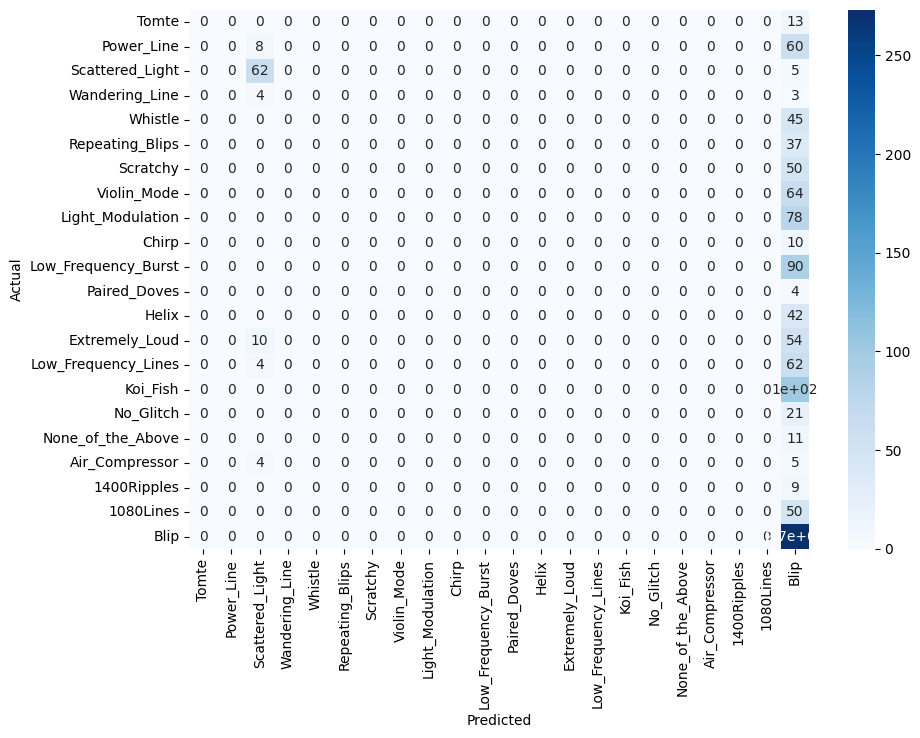

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,7))

# Use seaborn heatmap for visualization
sns.heatmap(cm, annot=True, cmap='Blues', xticklabels=classes, yticklabels=classes)

plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.show()